In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from models.stylegan2.model import StyleSpace
from models.psp import pSp
from img2tab import Img2Tab
from xgboost import XGBClassifier

from utils.demo_utils import *
from argparse import Namespace

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')
print(f'PyTorch version = {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device = cuda:1
PyTorch version = 1.12.1


# Img2Tab Demo
- Dataset : CelebA face dataset
- Tasks : perceived gender and age classifications
- GAN inversion : FFHQ pre-trained e4e
- Classifier $P$ : XGBoost

## Perceived Gender Classification

In [15]:
gender_model = Img2Tab('gender', device)

Encoder and Generator have been loaded successfully!
G,E, and P initialized successfully!


This person is perceived as not Male.
Top 4 important concept's k for gender: [4319, 503, 4440, 4614]


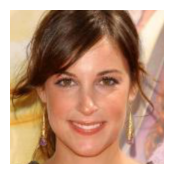

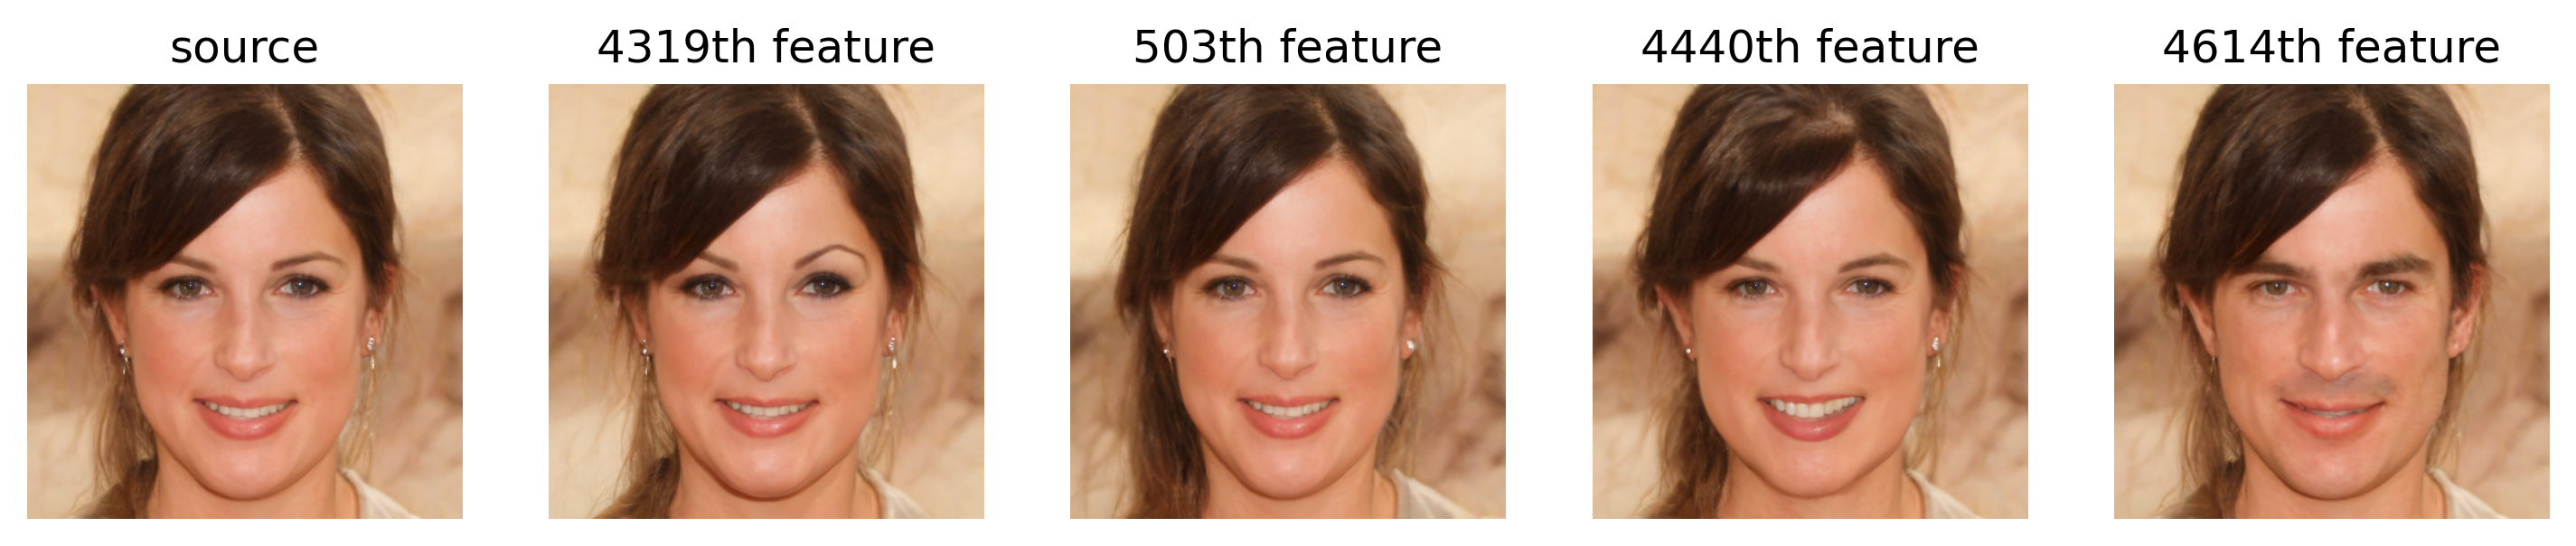

In [6]:
path = 'datasets/demo_sample.jpg'
image = get_image_from_path(path).to(device)
gender_prediction = gender_model.predict(image, 'Male')
n_concepts = 4
gender_imps, gender_top_concepts = gender_model.get_important_concepts(n=n_concepts)
print(f"Top {n_concepts} important concept's k for gender: {gender_top_concepts[:n_concepts]}")

gender_lambda_list = [-100,200,-150,-15]
gender_model.visualize_concepts(image, gender_top_concepts, gender_lambda_list)

<BarContainer object of 4 artists>

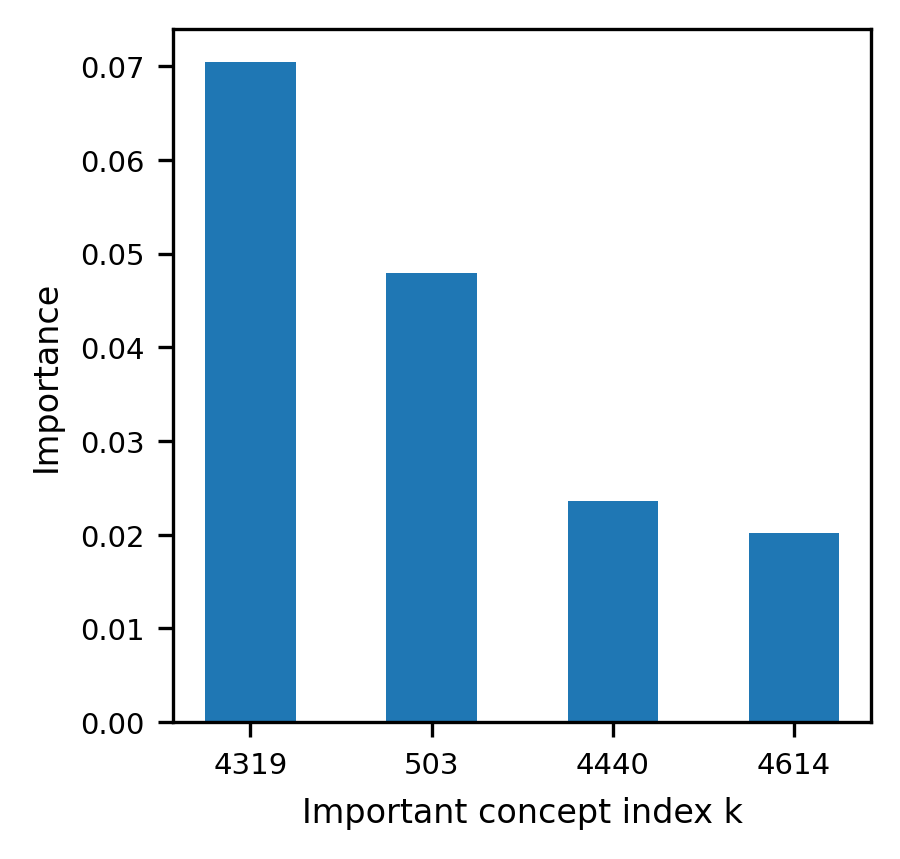

In [7]:
""" 
4319th feature = 'Makeup'
503th feature = 'Hair Length'
4440th feature = 'Smiling'
4614st feature = 'Facial hair'
"""
x_axis = [str(x) for x in gender_top_concepts]
# x_axis = ['Makeup', 'Hair Length', 'Smiling','Facial Hair']
y_axis = [gender_imps[x] for x in gender_top_concepts]

plt.figure(figsize=(3,3), dpi=200)
plt.xlabel("Important concept index k", fontsize=8)
plt.ylabel("Importance", fontsize=8)
plt.xticks(rotation=0, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.bar(x_axis, y_axis, width=0.5)

## Pereceived Age Classification

In [61]:
age_model = Img2Tab('age', device)

Encoder and Generator have been loaded successfully!
G,E, and P initialized successfully!


This person is perceived as Young.
Top 4 important concept's k: [4989, 3450, 7317, 5043]


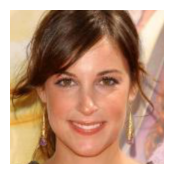

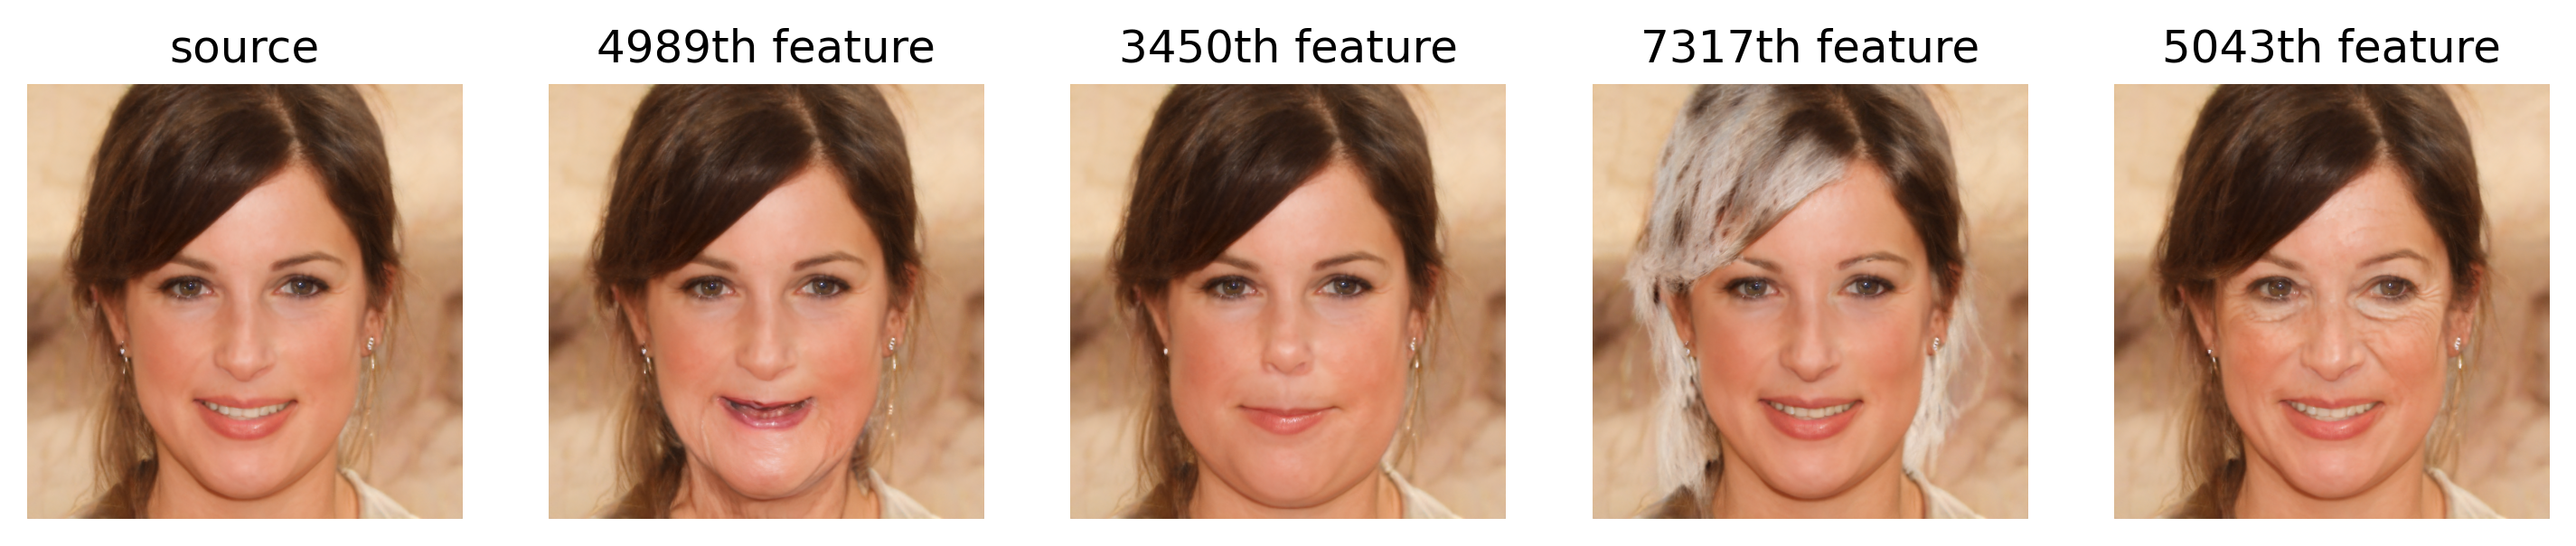

In [62]:
attr = 'Young'
path = 'datasets/demo_sample.jpg'
image = get_image_from_path(path).to(device)
age_prediction = age_model.predict(image, attr)
age_imps, age_top_concepts = age_model.get_important_concepts()
print(f"Top 4 important concept's k: {age_top_concepts[:4]}")

lambda_list = [-30,20,-40,20]
age_model.visualize_concepts(image, age_top_concepts, lambda_list)

<BarContainer object of 4 artists>

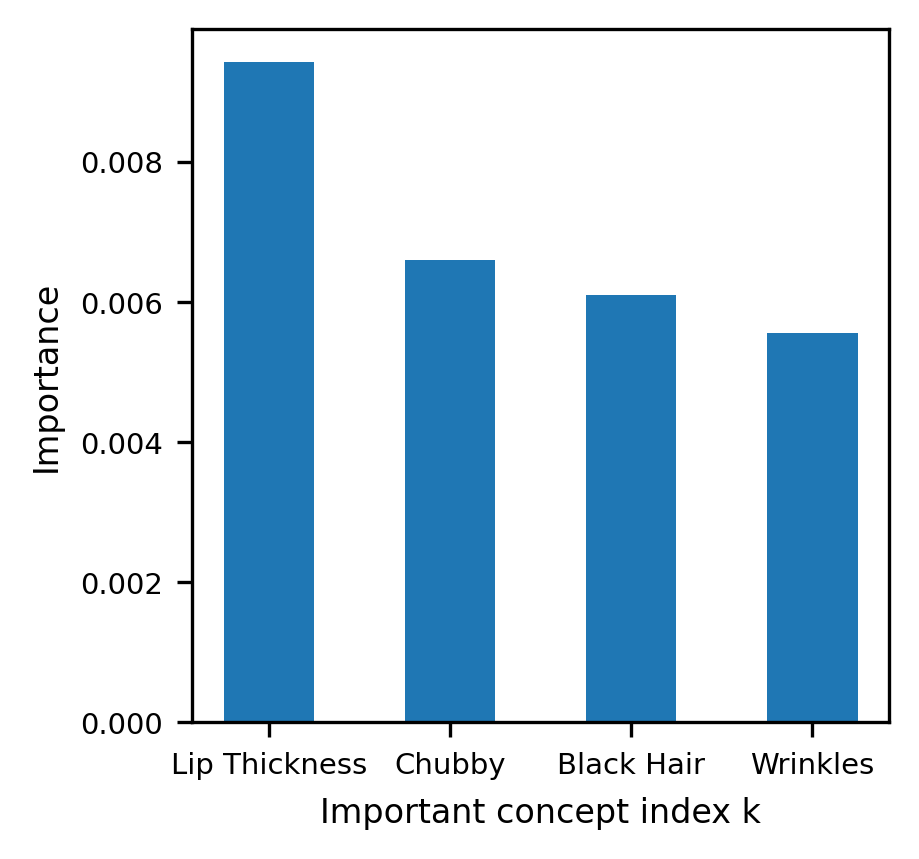

In [64]:
""" 
4989th feature = 'Lip Thickness'
3450th feature = 'Chubby'
7317th feature = 'Black Hair'
5043st feature = 'Wrinkles'
"""
x_axis = [str(x) for x in age_top_concepts]
x_axis = ['Lip Thickness', 'Chubby', 'Black Hair','Wrinkles']
y_axis = [age_imps[x] for x in age_top_concepts]

plt.figure(figsize=(3,3), dpi=200)
plt.xlabel("Important concept index k", fontsize=8)
plt.ylabel("Importance", fontsize=8)
plt.xticks(rotation=0, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.bar(x_axis, y_axis, width=0.5)

# Measure $W_k$ of given $k$-th feature
- This section shows that $W_k$ method can reveal class-relevant concepts from StyleGAN features automatically.
- In the paper, we use this method for quantitatively determining the best tabular classifier which can discover class-relevant concepts by themselves automatically.


In [ ]:
# Perceived gender classification
model = Img2Tab('gender', device)
Psi_matrix = np.load('datasets/standard_Psi_matrix.npy')
Psi_is_standardized = True
label = to_np(torch.load(f'datasets/Psi_and_labels/Male_train_labels.pt'))
Wk_list = list(get_Wk_list(label, Psi_matrix, Psi_is_standardized))

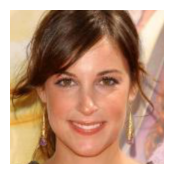

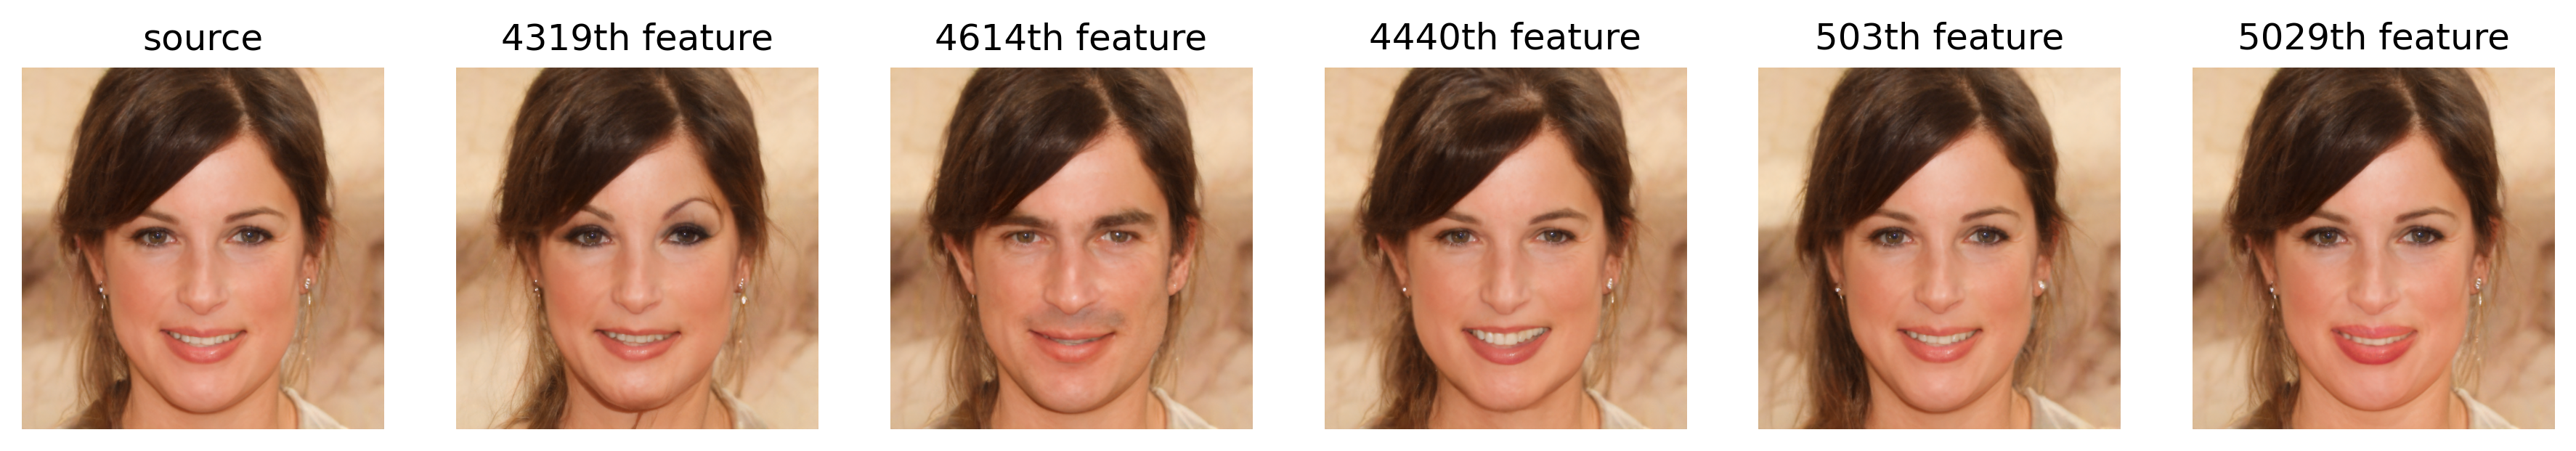

In [ ]:
Wk_top_concepts = [Wk_list.index(x) for x in sorted(Wk_list, reverse=True)][:5]
path = 'datasets/demo_sample.jpg'
image = get_image_from_path(path).to(device)
Wk_lambda_list = [-190, -15,-150,160,10]
model.visualize_concepts(image, Wk_top_concepts, Wk_lambda_list)

# Img2Tab debugging for unbiased and fair decision-making
- Since 4319th and 4440th feature, concepts of 'Makeup' and 'Smiling' respectively, are unfair and biased feature, we debug classifier so that it does not include them as important concepts. 

### Importance before debugging

In [5]:
gender_model = Img2Tab('gender', device)

Img2Tab networks have been loaded successfully!


Top 6 important concept's k for gender: [4319, 503, 4440, 4614, 375, 5078]


<BarContainer object of 6 artists>

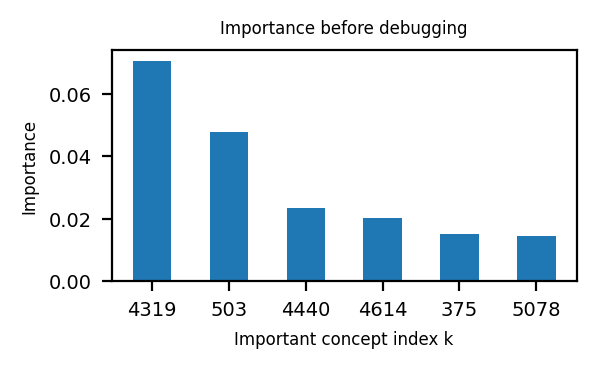

In [6]:
n_concepts = 6
gender_imps, gender_top_concepts = gender_model.get_important_concepts(n=n_concepts)
print(f"Top {n_concepts} important concept's k for gender: {gender_top_concepts[:n_concepts]}")
x_axis = [str(x) for x in gender_top_concepts]
# x_axis = ['Makeup', 'Hair Length', 'Smiling','Facial Hair']
y_axis = [gender_imps[x] for x in gender_top_concepts]

plt.figure(figsize=(3,2), dpi=200)
plt.title("Importance before debugging", fontsize=6)
plt.xlabel("Important concept index k", fontsize=6)
plt.ylabel("Importance", fontsize=6)
plt.xticks(rotation=0, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.bar(x_axis, y_axis, width=0.5)

### Importance after debugging

In [7]:
unwanted_k = [4319, 4440]
Psi_matrix = np.load('datasets/standard_Psi_matrix.npy')
gender_label = to_np(torch.load(f'datasets/Psi_and_labels/Male_train_labels.pt'))

gender_model.debug_classifier(unwanted_k, Psi_matrix, gender_label)

Top 4 important concept's k for gender: [503, 4614, 5029, 5994]


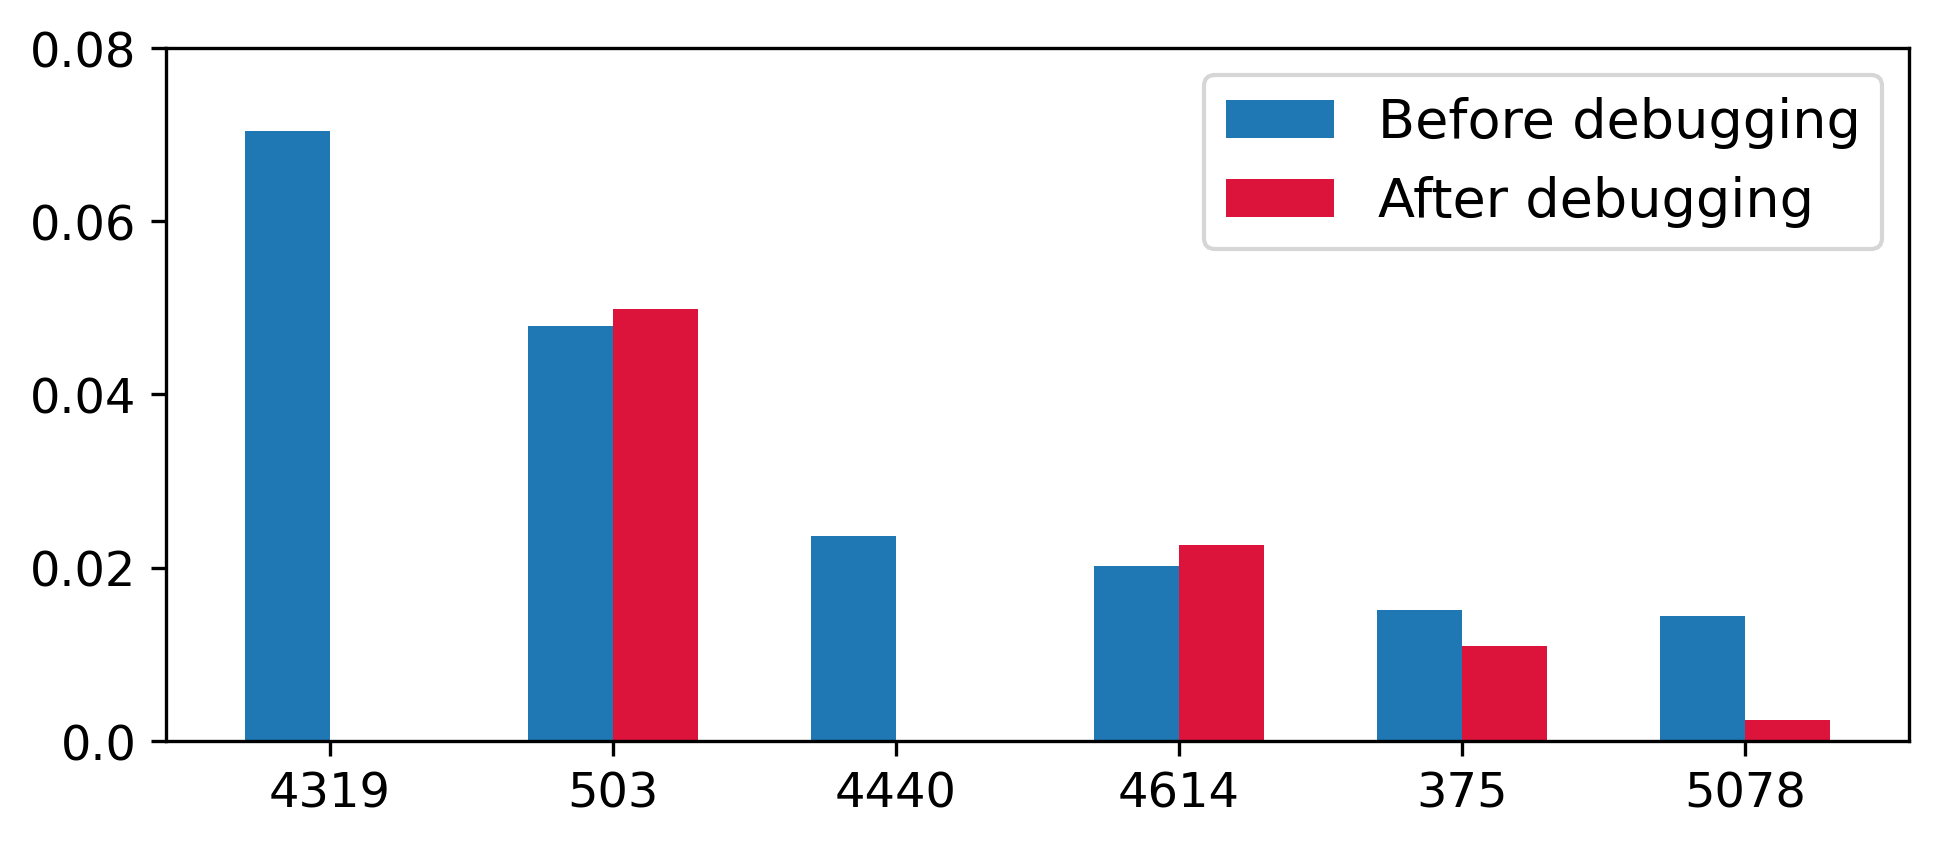

In [8]:
fig = plt.figure(figsize=(7.5,3), dpi=300)
ax = fig.add_subplot(111)

x_before = [str(x) for x in gender_top_concepts]
# x_axis = ['Makeup', 'Hair Length', 'Smiling','Facial Hair']
y_before = [gender_imps[x] for x in gender_top_concepts]

n_concepts = 4
debug_imps, debug_top_concepts = gender_model.get_important_concepts(n=n_concepts)
print(f"Top {n_concepts} important concept's k for gender: {debug_top_concepts[:n_concepts]}")
x_after = [str(x) for x in debug_top_concepts]
# x_axis = ['Makeup', 'Hair Length', 'Smiling','Facial Hair']
y_after = [debug_imps[x] for x in gender_top_concepts]

x_tick = np.arange(6)
y_tick = np.arange(0,0.09,0.02)
bar1 = ax.bar(x_tick-0.15, y_before, 0.3)
bar2 = ax.bar(x_tick+0.15, y_after, 0.3, color='crimson')

ax.set_xticks(x_tick)
ax.set_yticks(y_tick,fontsize=12)
ax.set_yticklabels(tuple(y_tick), fontsize=11.5)
ax.set_xticklabels(tuple(x_axis), fontsize=11.5)
ax.legend(('Before debugging', 'After debugging'), fontsize=13)
plt.show()